In [64]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 5 5 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]]


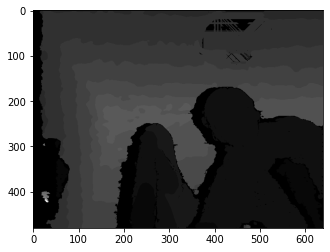

In [372]:
# image_depth = cv2.imread('data/20201219_073658/depth/depth023307409300.png', 0)
image_depth = cv2.imread('data/20201219_073658/depth/depth000023966100.png', 0)
print(image_depth)
plt.imshow(image_depth, cmap='gray')

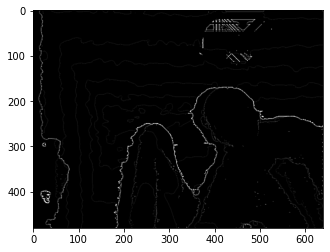

In [367]:
laplacian = cv2.Laplacian(image_depth, cv2.CV_8U, ksize=5)
plt.imshow(laplacian, cmap='gray')

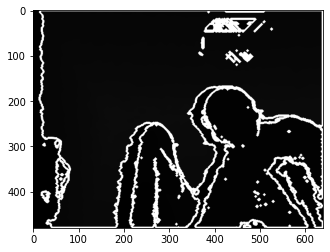

In [369]:
contours, hierarchy = cv2.findContours(image_depth, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img = cv2.drawContours(image_depth, contours, -1, (255,255,255), 3)
plt.imshow(img, cmap='gray')

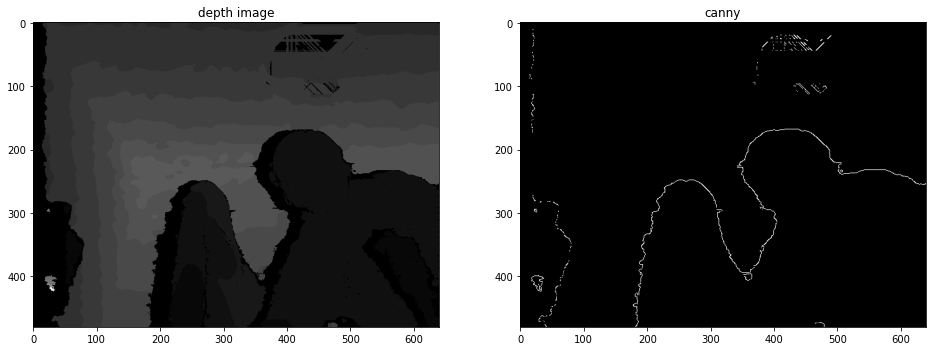

In [371]:
# detect green area
# _thres, img_green = cv2.threshold(img_Lab_a, 110, 255, cv2.THRESH_BINARY_INV)

img_canny = cv2.Canny(image_depth, 30, 35)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('depth image')
plt.imshow(image_depth, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('canny')
plt.imshow(img_canny, cmap='gray')

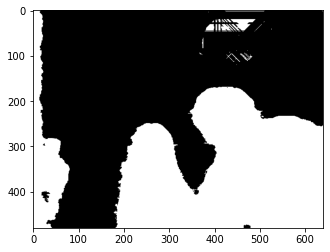

In [373]:
ret, thresh = cv2.threshold(image_depth, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

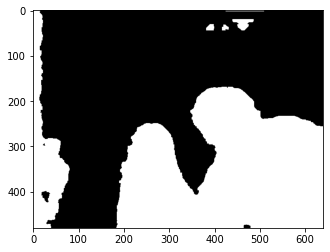

In [374]:
# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# # Finding sure foreground area
# dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
# ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# # Finding unknown region
# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg,sure_fg)

plt.imshow(opening, cmap='gray')

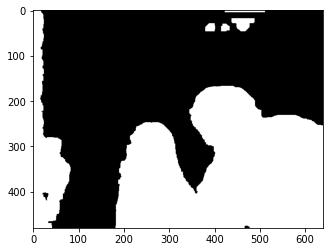

In [375]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=2)
plt.imshow(sure_bg, cmap='gray')

[[ 15  14  13 ...   0   0   0]
 [ 15  14  13 ...   0   0   0]
 [ 15  14  13 ...   0   0   0]
 ...
 [ 30  29  28 ... 158 159 160]
 [ 30  29  28 ... 158 159 160]
 [ 30  29  28 ... 158 159 160]]


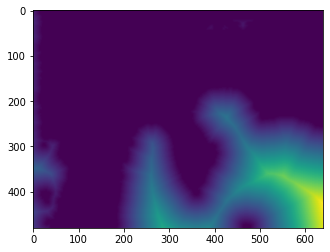

In [376]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
dist_transform = np.uint16(dist_transform)
print(dist_transform)
plt.imshow(dist_transform)

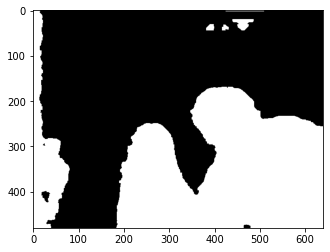

In [385]:
# Finding sure foreground area
ret, sure_fg = cv2.threshold(dist_transform, 0.005 * dist_transform.max(), 255, 0)
plt.imshow(sure_fg, cmap='gray')

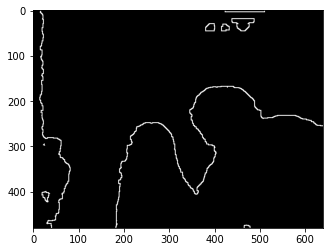

In [386]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

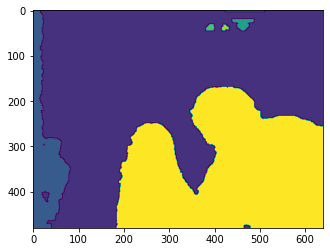

In [387]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers)

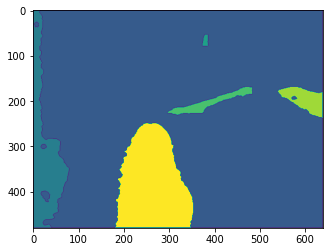

In [339]:
color = cv2.cvtColor(image_depth, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(color, markers)
plt.imshow(markers)

True

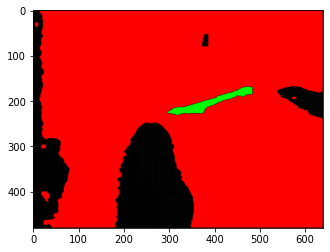

In [345]:
color = cv2.cvtColor(image_depth, cv2.COLOR_GRAY2RGB)
# color[markers == -1] = [255, 0, 0]
color[markers == 1] = [255, 0, 0]
color[markers == 4] = [0, 255, 0]
color = o3d.geometry.Image(color)
color = np.array(color)
plt.imshow(color)
cv2.imwrite('tmp.png', color)

In [348]:
import open3d as o3d

# cv2.imwrite('tmp.png', color)
color_raw = o3d.io.read_image('data/20201219_073658/color/color023307409300.png')
# color_raw = o3d.io.read_image('tmp.png')
depth_raw = o3d.io.read_image('data/20201219_073658/depth/depth023307409300.png')
depth_raw = np.array(depth_raw)
depth_raw[markers != 4] = 0
depth_raw = o3d.geometry.Image(depth_raw)
# print(depth_raw)
# rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(color), depth_raw)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)

In [349]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

o3d.visualization.draw_geometries([pcd])

In [350]:
# pcd_arrow = pcd
pcd_arrow, ind = pcd.remove_radius_outlier(nb_points=16, radius=0.05)
obb = pcd_arrow.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([pcd, obb])

In [351]:
color_raw = o3d.io.read_image('data/20201219_073658/color/color023307409300.png')
depth_raw = o3d.io.read_image('data/20201219_073658/depth/depth023307409300.png')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)

pcd_all = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

o3d.visualization.draw_geometries([pcd_all, obb])

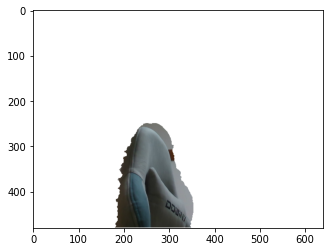

In [340]:
image_color = cv2.imread('data/20201219_073658/color/color023307409300.png')
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
image_color[markers != 6] = [255, 255, 255]
plt.imshow(image_color)